In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_emotion.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [7]:
df = df.dropna(subset='향기', axis=0).reset_index(drop=True)

In [8]:
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,"머리를 감았는데 감은건지 안감은건지 기름진거 같고, 몇사간지나면 떡진것 같이 보여요...",1,20.11.20.,라보에이치,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,탈모는 기존과 동일합니다. 향이 너무 자극적이어서 눈이 따갑습니다.,1,21.01.28.,이지마인드,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,"한달써보고 남기는 후기! 저는 어렸을적부터 모발이얇은편이고 펌,염색을자주하다보니 결...",2,20.04.24.,라보에이치,NaN,0.0,0.0,0.0,NaN,NaN,NaN
3,탈모삼푸 많이 사용해봣는데 별루네요 향이 약간 고무냄새(?) ㅠㅠ 다른 거랑 번갈아...,2,20.03.30.,라보에이치,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,양이 많고 향도 좋지만 내 두피랑은 잘 안맞았던 것 같음ㅠㅠ 각질도 일어나고.......,2,21.01.09.,이지마인드,NaN,NaN,1.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
775,샴푸향도 좋고 머릿결이 좋아지는 느낌이에요!,5,22.01.14.,반코르,NaN,NaN,1.0,NaN,NaN,NaN,1.0
776,시원하고 향도 좋네요 워낙 유명해서 구매해봤는데 남편이랑 저랑 며칠 써 본 결과로는...,5,21.12.17.,반코르,NaN,1.0,1.0,1.0,NaN,1.0,NaN
777,은은하게 기분좋게 만드는 향이 젤 맘에 들었으며 거품도 풍성하게 울아들은 머리감고 ...,5,22.01.09.,반코르,NaN,1.0,1.0,1.0,NaN,NaN,NaN
778,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      780 non-null    object 
 1   score        780 non-null    int64  
 2   date         780 non-null    object 
 3   brand        780 non-null    object 
 4   가격           162 non-null    float64
 5   세정력/거품       367 non-null    float64
 6   향기           780 non-null    float64
 7   트러블/진정       202 non-null    float64
 8   배송/서비스/고객대응  51 non-null     float64
 9   탈모 효과 및 쿨링감  142 non-null    float64
 10  머릿결*         200 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 67.2+ KB


In [10]:
target = df.iloc[:,6].to_numpy().reshape(-1,1)
target

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [11]:
target = (target == 0).astype(int)

In [12]:
model_name = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained("jaehyeong/koelectra-base-v3-generalized-sentiment-analysis")

In [13]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [14]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((780, 512), (780, 512), (780, 512))

In [15]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y_1=None, y_2=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y_1 = y_1


    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y_1 is not None:
            item['y_1'] = torch.Tensor(self.y_1[idx])

        return item

In [16]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [17]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 이진분류 loss
        bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [18]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_1_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y_1") is not None:
            bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred_1 = sig(pred).to("cpu").numpy()

        pred_1_list.append(pred_1)

    pred_1 = np.concatenate(pred_1_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred_1

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [20]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred)
        recall = recall_score(target[vai], pred)
        precision = precision_score(target[vai], pred)
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_emotion_scent_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 5:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

f1_score_1: 0.7647058823529411
recall: 0.7222222222222222
precision: 0.8125
train_loss: 0.34101931031984395
valid_loss: 0.17383244394873962


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

f1_score_1: 0.7999999999999999
recall: 0.7777777777777778
precision: 0.8235294117647058
train_loss: 0.19611687099752137
valid_loss: 0.11241822322018635


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

f1_score_1: 0.8717948717948718
recall: 0.9444444444444444
precision: 0.8095238095238095
train_loss: 0.10533585631025907
valid_loss: 0.0952188989911706


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

f1_score_1: 0.8333333333333334
recall: 0.8333333333333334
precision: 0.8333333333333334
train_loss: 0.05845504636183763
valid_loss: 0.10069020281139857


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [20]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [21]:
test = pd.read_csv(f"{DATA_PATH_test}test_emotion.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [22]:
test = test.dropna(subset='향기', axis=0).reset_index(drop=True)

In [23]:
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,각질 엄청 생기네요 샴푸바꾸니 바로 없어짐 향도 별로고 비추천,1,20.06.11.,라보에이치,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,머리 숱이 적고 가늘긴 한데 세정후 건조함이 심하게 느껴지네요. 머리엉킴도 있었...,2,20.03.31.,라보에이치,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,계속 사용해보니 향도 그냥저냥이고 쩜 별루인데 나랑 안맞는건가?????요,2,21.04.17.,이지마인드,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,사용후 머릿결이 좋아졌다는건 아닌것같고 향도 별루구요,2,21.02.24.,이지마인드,NaN,NaN,0.0,NaN,NaN,NaN,0.0
4,향이 좀 역해요 거품은 잘 나네요,2,20.08.25.,이지마인드,NaN,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
191,배송 빠릅니다 안그래도 사야했는데 11행사로 쟁여놨네요 정말 머릿결 부드럽고 ...,5,22.11.08.,반코르,NaN,1.0,1.0,NaN,1.0,NaN,1.0
192,샴푸는 정착했어요! 향도 좋고 엉킴도 없이 머릿결에 도움이 됩니다,5,22.09.30.,반코르,NaN,NaN,1.0,NaN,NaN,NaN,1.0
193,은은한 향 거품도 잘 나고 순하게 두피를 씻어내는 느낌이예요! 머릿결도 부드럽게 씻...,5,22.07.28.,반코르,NaN,1.0,1.0,NaN,NaN,NaN,1.0
194,거품이 풍성하게 잘 나요. 향도 맘에 들고요. 환절기에 비듬케어하는 샴푸를 썼더니 ...,5,21.12.22.,반코르,NaN,1.0,1.0,NaN,NaN,1.0,NaN


In [24]:
test_target = test.iloc[:,6].to_numpy().reshape(-1,1)
test_target

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [25]:
test_target = (test_target == 0).astype(int)

In [26]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [27]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((196, 512), (196, 512), (196, 512))

In [28]:
batch_size = 4

In [29]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_emotion_scent_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [30]:
pred = (pred > 0.5).astype(int)

In [31]:
pred.shape

(196, 1)

In [32]:
f1_score(test_target, pred)

0.9056603773584906

In [33]:
recall_score(test_target, pred)

0.8275862068965517

In [34]:
precision_score(test_target, pred)

1.0

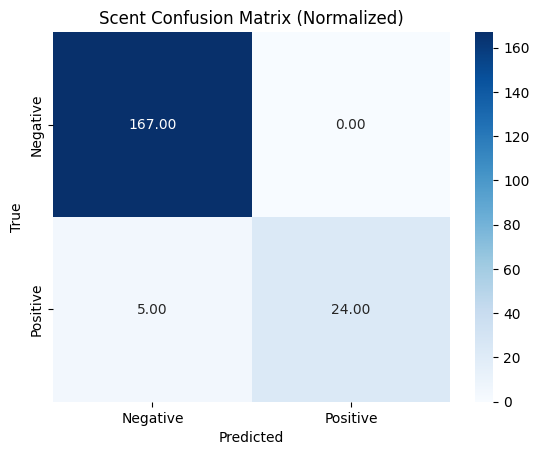

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_target, pred)
labels = ['Negative', 'Positive']  # 이진 분류 레이블
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
# title 에서 앞부분 본인 주제에 맞는 걸로 바꿔주세요.
plt.title('Scent Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()